# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import tests

In [3]:
RANDOM_STATE = 2020

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [4]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=RANDOM_STATE)

# Homework part 1. Implementation of Random Forest Classifier.

## Splitting criteria

**Task 1 - 2 points.** In this section you should implement two criteria for splitting of the feature space. Any of these can be used in the model.

### Gini index

0.5 points for *gini_index* function

In [6]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    if len(x)<=1: return 0.0
    
    unique, counts = np.unique(x, return_counts=True)
    return 1 - np.sum(np.power(counts/np.sum(counts), 2))

In [7]:
tests.test_gini_index(gini_index)

 All good!


0.5 points for *gini_gain* function

In [8]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       

    parent_idx = gini_index(parent_node)
    
    split_idx_0 = gini_index(splits[0])
    split_idx_1 = gini_index(splits[1])
    w_0 = len(splits[0])/(len(splits[0]) + len(splits[1]))
    w_1 = len(splits[1])/(len(splits[0]) + len(splits[1]))
    split_idx = split_idx_0*w_0 + split_idx_1*w_1

    return parent_idx - split_idx

In [9]:
tests.test_gini_gain(gini_gain)

 All good!


### Entropy

0.5 points for *entropy* function

In [10]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    # If you use vectorized operations on a vector of frequencies p
    # where some of the relative frequencies may be 0, and you need to evaluate
    # the expression p * np.log(p), you can use the "where" argument of the np.log() function.
    # This will leave those elements of the array untouched by the function, 
    # thus evaluating x*log(x) as zero, exactly as we want it to be.
#     pass
    unique, counts = np.unique(x, return_counts=True)
    p = counts/(np.sum(counts))
    return -np.dot(p, np.transpose(np.log(p, where=p>0)))
    

In [11]:
tests.test_entropy(entropy)

 All good!


0.5 points for *information_gain* function

In [12]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    
    parent_ent = entropy(parent_node)
    
    split_ent_0 = entropy(splits[0])
    split_ent_1 = entropy(splits[1])
    w_0 = len(splits[0])/(len(splits[0]) + len(splits[1]))
    w_1 = len(splits[1])/(len(splits[0]) + len(splits[1]))
    split_ent = split_ent_0*w_0 + split_ent_1*w_1

    return parent_ent - split_ent

In [13]:
tests.test_information_gain(information_gain)

 All good!


## Split function

**Task 2 - 1 point** Implement *split_dataset* function. <br>
The rows of the dataframe received by a tree node are split into two dataframes depending on their values in a selected column. Rows with values smaller than the chosen threshold are stored in the resulting left dataframe, and we save rows with values larger than the threshold in the right dataframe. The array with target values should be split in accordance with the feature dataframe.

In [14]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    
    left_mask = X[:,column] < value
    right_mask = X[:,column] >= value
    left_y, right_y = split(X[:,column], y, value)
    left_X, right_X = X[left_mask,:], X[right_mask,:]
    return left_X, right_X, left_y, right_y

In [15]:
tests.test_split_dataset(split_dataset)

 All good!


## Decision tree

**Task 3 - 4.5 points** In the Tree class below you need to complete the *fit(), predict_row()* and *predict()* functions.<br>
Each tree is basically a tree node that may have a left and a right child that are also trees. If a tree doesn't have any child nodes, we call it a leaf.<br>
Since features for splitting a dataframe are chosen randomly, we need a mechanism to control this randomness to aquire reproducibility for testing purposes. In our case we use the [Random Generator](https://numpy.org/doc/stable/reference/random/generator.html)<br>
By creation of a tree only the **criterion** and the **rng** fields are not filled with Nones, so each tree knows what criterion for dataframe splitting it should use. Each fitted tree knows as well by which column and value the split should be performed. If a tree is a leaf it doesn't have information about the split, but stores the predicted value.

In [16]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """
    def __init__(self, criterion='gini', random_gen=None):
        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion
        self.threshold = None           # value of the next split
        self.column_index = None        # column to use for the next split
        self.outcome_probs = None       # the predicted value if the tree is a leaf
        self.left_child = None
        self.right_child = None
        self.rng = random_gen if random_gen is not None else np.random.default_rng()

    @property
    def is_terminal(self):
        """Define is it terminal node."""          
        return not bool(self.left_child and self.right_child)
    
    def _compute_gain(self, y, splits):
        """Compute split gain according to chosen criteria."""
        func = gini_gain if self.criterion == 'gini' else information_gain
        return func(y, splits)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""
        # Sample random subset of features
        subset = self.rng.choice(list(range(0, X.shape[1])), n_features, replace=False)

        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self._compute_gain(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain
    
    def _compute_outcome(self, y):
        """Save outcome probabilities for the leaf."""
        self.outcome_probs = np.around(np.sum(y) / y.shape[0])

    def _is_pure(self, y):
        """Check if current leaf is pure."""
        y_unique = list(np.unique(y))
        return len(y_unique) == 1
    
    def fit(self, X, y, feature_frac=1.0, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array):      The training input samples. 2-dimensional numpy array.
            y (numpy-array):      The target values. 1-dimensional numpy array.
            feature_frac (float): The fraction of features to use when fit is performed. Must be 
                                  between 0.0 and 1.0 (default: 1.0, i.e. all features).
            max_depth (int):      The maximum depth of the tree. If None, then nodes are expanded
                                  until all leaves are pure.
        """
        # 3 points

        # Make this tree a leaf and return if max_depth doesn't allow it to grow further
        if max_depth is not None and max_depth <= 0 :
            self._compute_outcome(y)
            return
        
        if not 0.0 <= feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')
        # Compute the number of features to use. Should be integer number
        n_features = int(X.shape[1]*feature_frac)
        
        # Find the next split    
        column, value, gain = self._find_best_split(X, y, n_features)
        
        # Make this tree a leaf and return if the split doesn't bring any gain
        if gain is None or gain <= 0:
            self._compute_outcome(y)
            return
        
        # Save the necessary information about the next split
        self.threshold = value           # value of the next split
        self.column_index = column       # column to use for the next split
        
        # Reduce the max_depth parameter for the next tree
        if max_depth is not None:
            max_depth -= 1

        if self._is_pure(y):
            self._compute_outcome(y)
            return
    
        # Split dataset
        left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

        # Grow left and right child. Pass over the parent's random generator
        # for reproducible results 
        self.left_child = Tree(criterion=self.criterion, random_gen=self.rng)
        self.left_child.fit(X=left_X, y=left_target, feature_frac=feature_frac, max_depth=max_depth)

        self.right_child = Tree(criterion=self.criterion, random_gen=self.rng)
        self.right_child.fit(X=right_X, y=right_target, feature_frac=feature_frac, max_depth=max_depth)

    def predict_row(self, row):
        """Predict single row."""
        # 0.5 points
        
        if not self.is_terminal:
            # Use the stored information about the split to define 
            # if the right or the left child to use
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return 0 if self.outcome_probs < 0.5 else 1

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        Returns:
            1-dimensional numpy-array with predictions     
        """ 
        # 1 point
        
        # Create a numpy array of zeros of necessary length to save predictions
        result = np.zeros(X.shape[0])
        # Go through all rows of the dataset
        for i in range(X.shape[0]):
            # Save the prediction for the current row
            result[i]= self.predict_row(X[i,:])
    
        return result

In [17]:
tests.test_tree(Tree)

 All good!


**Task 4 - 1 point** Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. **Explain** the results.

In [33]:
model_depth_3 = Tree(criterion='gini');
model_depth_3.fit(X_train.values, y_train.values, max_depth=3)

train_score_depth_3 = accuracy_score(y_train, model_depth_3.predict(X_train.values))
test_score_depth_3 = accuracy_score(y_test, model_depth_3.predict(X_test.values))
print('Perfomance of Decision Tree with `max_depth=3`:')
print(f'Train score = {train_score_depth_3}')
print(f'Test score = {test_score_depth_3}')

Perfomance of Decision Tree with `max_depth=3`:
Train score = 0.927710843373494
Test score = 0.6666666666666666


In [34]:
model_depth_none = Tree(criterion='gini');
model_depth_none.fit(X_train.values, y_train.values, max_depth=None)

train_score_depth_none = accuracy_score(y_train, model_depth_none.predict(X_train.values))
test_score_depth_none = accuracy_score(y_test, model_depth_none.predict(X_test.values))
print('Perfomance of Decision Tree with `max_depth=None`:')
print(f'Train score = {train_score_depth_none}')
print(f'Test score = {test_score_depth_none}')

Perfomance of Decision Tree with `max_depth=None`:
Train score = 1.0
Test score = 0.6666666666666666


In [24]:
def plot_metrics_on_depths(criterion='gini'):
    max_depths, train_scores, test_scores = [], [], []
    for max_depth in range(0, 8):
        max_depths.append(max_depth)
        model = Tree(criterion=criterion)
        model.fit(X_train.values, y_train.values, max_depth=max_depth)
        train_scores.append(accuracy_score(y_train, model.predict(X_train.values)))
        y_pred = model.predict(X_test.values)
        test_scores.append(accuracy_score(y_test, y_pred))
    res_metrics = pd.DataFrame(data={'train': train_scores, 'test': test_scores}, index=max_depths)
    sns.set(rc={'figure.figsize':(16, 6)})
    plt.plot(res_metrics['train'], label='train score')
    plt.plot(res_metrics['test'], label='test score')
    plt.title("Accuracy as a function of max_depth")
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show();

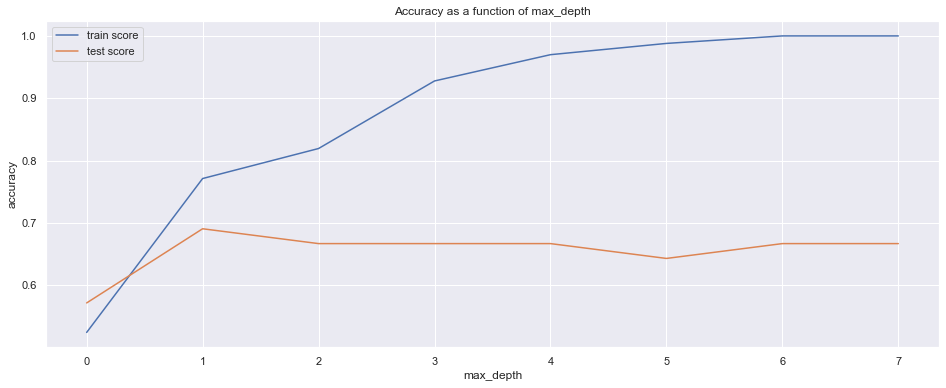

In [25]:
plot_metrics_on_depths('gini')

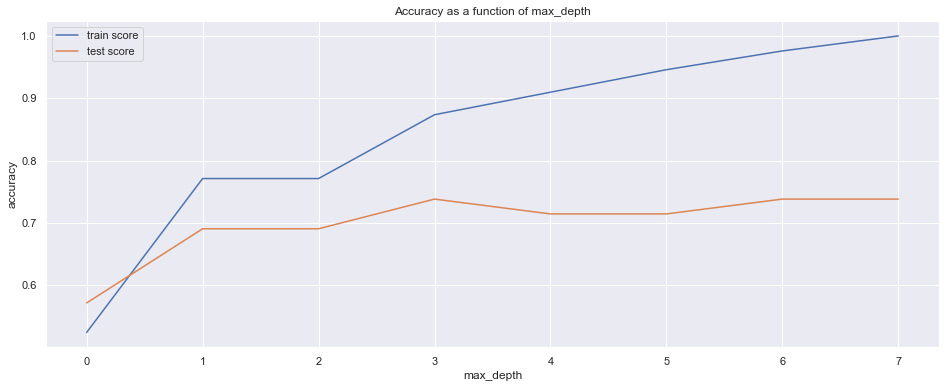

In [26]:
plot_metrics_on_depths('entropy')

**Выводы:**
- При использовании параметра `max_depth=None` точность распознавания на обучающей выборке составляет `Train score = 1.0`, а на тестовой выборке - `Test score = 0.667`. Иными словами, имеет место эффект переобучения (overfitting), т.е. дерево слишком хорошо описывает обучающую выборку.
- Ограничение максимальной глубины дерева позволяет предотвратить переобучение. При этом точность на тестовой выборке осталась аналогичной `Test score = 0.667`.

## Random forest

**Task 5 - 1.5 Points** In the RandomForestClassifier class below you need to complete the *fit* and *predict()* functions

In [57]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        feature_frac : float, default=None
            The fraction of features to use when looking for the best split. Must be 
            between 0.0 and 1.0. If None, then `feature_frac = 1 / sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
            
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """

    def __init__(self, n_estimators=10, max_depth=None, feature_frac=None, 
                 criterion="entropy", bootstrap=True, random_gen=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.feature_frac = feature_frac
        
        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion
        
        self.rng = random_gen if random_gen is not None else np.random.default_rng()
        self.trees = [Tree(criterion=self.criterion, random_gen=self.rng) 
                            for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return self.rng.integers(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """
        # 0.5 points
        
        if self.feature_frac is None:
            self.feature_frac = 1 / np.sqrt(X.shape[1])
        elif not 0.0 <= self.feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')
            
        self._init_data(X, y)
        
        # Iterate over all trees in the forest
#         for tree in None:
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            # Fit the tree    
#             pass
            tree.fit(X, y, feature_frac=self.feature_frac, max_depth=self.max_depth)
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """
        # 1 point
        
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            # Create a numpy array of zeros of necessary length
            predictions = np.zeros(X.shape[0])
            
            # Go through all rows of the dataset
            for i in range(X.shape[0]):
                # Initialize a counter for voting
                row_pred = 0
                # Sum up predictions from all the voters
                for tree in self.trees:
                    row_pred += tree.predict(np.array([X[i,:]]))[0]
                # Compute the mean of the votes    
                row_pred = row_pred/len(self.trees)
                # Save the rounded value as the prediction for the current row
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

In [58]:
tests.test_random_forest(RandomForestClassifier)

 All good!


**Task 6 - 1 Point** Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. **Explain** the results.

- Проведем анализ Random Forest Classfier c `n_estimators=10`

In [61]:
rfc_10 = RandomForestClassifier(n_estimators=10, max_depth=3)
rfc_10.fit(X_train, y_train)

train_score_10 = accuracy_score(y_train, rfc_10.predict(X_train.values))
test_score_10 = accuracy_score(y_test, rfc_10.predict(X_test.values))
print('Perfomance of Random Forest Classfier with `n_estimators=10`:')
print(f'Train score = {train_score_10}')
print(f'Test score = {test_score_10}')

Perfomance of Random Forest Classfier with `n_estimators=10`:
Train score = 0.9036144578313253
Test score = 0.8333333333333334


In [63]:
train_score_10_list = np.zeros(10)
test_score_10_list = np.zeros(10)
for i in range(10):
    rfc_10.fit(X_train, y_train)
    train_score_10_list[i] = accuracy_score(y_train, rfc_10.predict(X_train.values))
    test_score_10_list[i] = accuracy_score(y_test, rfc_10.predict(X_test.values))

In [70]:
train_score_10_std = np.std(train_score_10_list)
train_score_10_mean = np.mean(train_score_10_list)

test_score_10_std = np.std(test_score_10_list)
test_score_10_mean = np.mean(test_score_10_list)

print(f'Train_score std/mean : {train_score_10_std} / {train_score_10_mean}')
print(f'Test_score std/mean : {test_score_10_std} / {test_score_10_mean}')

Train std/mean : 0.03204117143848724 / 0.8981927710843373
Test std/mean : 0.04517539514526255 / 0.7857142857142857


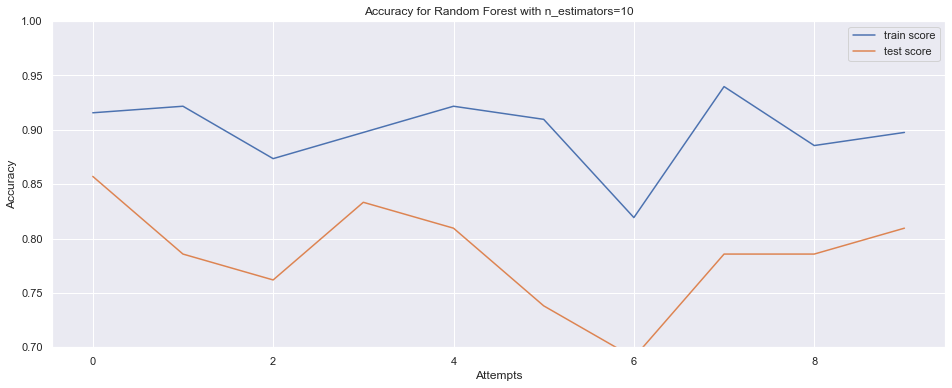

In [74]:
plt.plot(train_score_10_list, label='train score')
plt.plot(test_score_10_list, label='test score')
plt.title("Accuracy for Random Forest with n_estimators=10")
plt.xlabel('Attempts')
plt.ylabel('Accuracy')
plt.ylim((0.7,1))
plt.legend()
plt.show();

- Проведем анализ Random Forest Classfier c `n_estimators=100`

In [60]:
rfc_100 = RandomForestClassifier(n_estimators=100, max_depth=3)
rfc_100.fit(X_train, y_train)

train_score_100 = accuracy_score(y_train, rfc_100.predict(X_train.values))
test_score_100 = accuracy_score(y_test, rfc_100.predict(X_test.values))
print('Perfomance of Random Forest Classfier with `n_estimators=100`:')
print(f'Train score = {train_score_100}')
print(f'Test score = {test_score_100}')

Perfomance of Random Forest Classfier with `n_estimators=100`:
Train score = 0.9698795180722891
Test score = 0.8571428571428571


In [66]:
train_score_100_list = np.zeros(10)
test_score_100_list = np.zeros(10)
for i in range(10):
    rfc_100.fit(X_train, y_train)
    train_score_100_list[i] = accuracy_score(y_train, rfc_100.predict(X_train.values))
    test_score_100_list[i] = accuracy_score(y_test, rfc_100.predict(X_test.values))

In [69]:
train_score_100_std = np.std(train_score_100_list)
train_score_100_mean = np.mean(train_score_100_list)

test_score_100_std = np.std(test_score_100_list)
test_score_100_mean = np.mean(test_score_100_list)

print(f'Train std/mean : {train_score_100_std} / {train_score_100_mean}')
print(f'Test std/mean : {test_score_100_std} / {test_score_100_mean}')

Train std/mean : 0.013483752581686386 / 0.9475903614457831
Test std/mean : 0.03333333333333333 / 0.8047619047619048


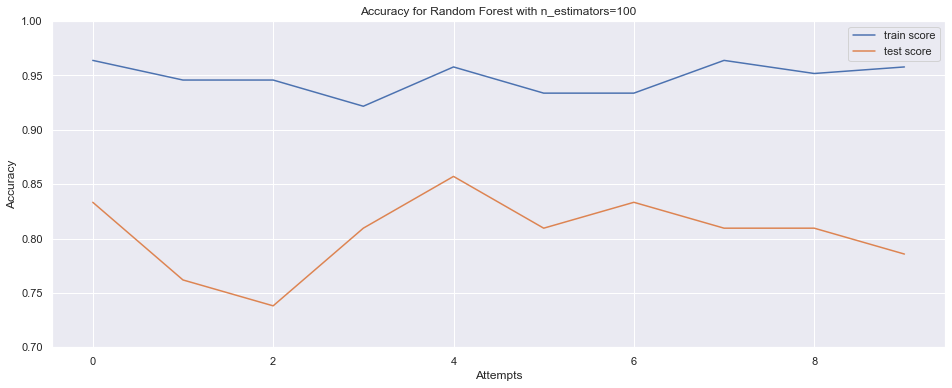

In [73]:
plt.plot(train_score_100_list, label='train score')
plt.plot(test_score_100_list, label='test score')
plt.title("Accuracy for Random Forest with n_estimators=100")
plt.xlabel('Attempts')
plt.ylabel('Accuracy')
plt.ylim((0.7, 1))
plt.legend()
plt.show();

**Выводы:**
- Увеличение числа деревьев (`n_estimators`) в  RandomForestClassifier не гарантирует повышение точности распознавания, однако позволяет повысить стабильность работы Random Forest за счет большей базы для усреднения. 
- При увеличении числа `n_estimators` с 10 до 100 для тестовой выборке было замечено следующее:
    - СКО точности распознавания снизилось с 0.045 до 0.033.
    - среднее значение точности распознавания увеличилось с 0.786 до 0.805.
- RandomForestClassifier обеспечивает значительно более высокую точность распознавания, чем одиночное решающее дерево (0.66 против 0.805).  

Now it's your turn to explore the various parameters of RandomForestClassifier and their influence on model quality.

# Homework part 2. Random Forest in action

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

_Note_: For tasks 1 to 5 please use your custom RandomForestClassifier if it is completed.

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [ ]:
# Your code here

### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

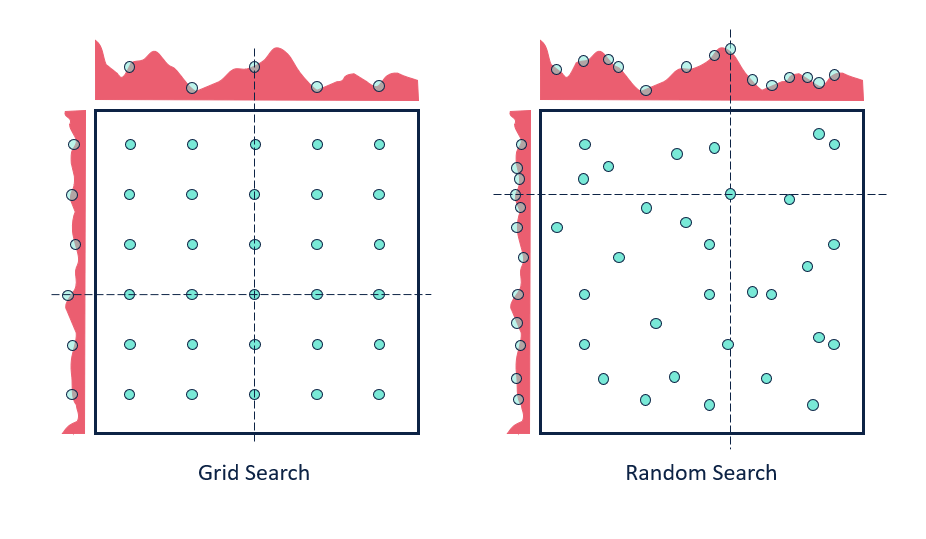

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [ ]:
# Your code here

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [ ]:
# Your code here

**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

Your cool ideas here...

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# your code here

Is it easy to interpret its results? Are you able to explain to a random person why would they survive / die on the titanic?